In [62]:
import pandas as pd
import glob
import torch, os
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast, TrainingArguments, Trainer, DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [63]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU')
else:
    device = torch.device("cpu")
    print('CPU')

GPU


In [64]:
train_paths = ['./content/train/california_wildfires_2018_train.tsv',
               './content/train/canada_wildfires_2016_train.tsv',
               './content/train/cyclone_idai_2019_train.tsv',
               './content/train/ecuador_earthquake_2016_train.tsv',
               './content/train/greece_wildfires_2018_train.tsv',
               './content/train/hurricane_dorian_2019_train.tsv',
               './content/train/hurricane_florence_2018_train.tsv',
               './content/train/hurricane_harvey_2017_train.tsv',
               './content/train/hurricane_irma_2017_train.tsv',
               './content/train/hurricane_maria_2017_train.tsv',
               './content/train/hurricane_matthew_2016_train.tsv',
               './content/train/italy_earthquake_aug_2016_train.tsv',
               './content/train/kaikoura_earthquake_2016_train.tsv',
               './content/train/kerala_floods_2018_train.tsv',
               './content/train/maryland_floods_2018_train.tsv',
               './content/train/midwestern_us_floods_2019_train.tsv',
               './content/train/pakistan_earthquake_2019_train.tsv',
               './content/train/puebla_mexico_earthquake_2017_train.tsv',
               './content/train/srilanka_floods_2017_train.tsv']

val_paths = ['./content/dev/california_wildfires_2018_dev.tsv',
             './content/dev/canada_wildfires_2016_dev.tsv',
             './content/dev/cyclone_idai_2019_dev.tsv',
             './content/dev/ecuador_earthquake_2016_dev.tsv',
             './content/dev/greece_wildfires_2018_dev.tsv',
             './content/dev/hurricane_dorian_2019_dev.tsv',
             './content/dev/hurricane_florence_2018_dev.tsv',
             './content/dev/hurricane_harvey_2017_dev.tsv',
             './content/dev/hurricane_irma_2017_dev.tsv',
             './content/dev/hurricane_maria_2017_dev.tsv',
             './content/dev/hurricane_matthew_2016_dev.tsv',
             './content/dev/italy_earthquake_aug_2016_dev.tsv',
             './content/dev/kaikoura_earthquake_2016_dev.tsv',
             './content/dev/kerala_floods_2018_dev.tsv',
             './content/dev/maryland_floods_2018_dev.tsv',
             './content/dev/midwestern_us_floods_2019_dev.tsv',
             './content/dev/pakistan_earthquake_2019_dev.tsv',
             './content/dev/puebla_mexico_earthquake_2017_dev.tsv',
             './content/dev/srilanka_floods_2017_dev.tsv']

test_paths = ['./content/test/california_wildfires_2018_test.tsv',
              './content/test/canada_wildfires_2016_test.tsv',
              './content/test/cyclone_idai_2019_test.tsv',
              './content/test/ecuador_earthquake_2016_test.tsv',
              './content/test/greece_wildfires_2018_test.tsv',
              './content/test/hurricane_dorian_2019_test.tsv',
              './content/test/hurricane_florence_2018_test.tsv',
              './content/test/hurricane_harvey_2017_test.tsv',
              './content/test/hurricane_irma_2017_test.tsv',
              './content/test/hurricane_maria_2017_test.tsv',
              './content/test/hurricane_matthew_2016_test.tsv',
              './content/test/italy_earthquake_aug_2016_test.tsv',
              './content/test/kaikoura_earthquake_2016_test.tsv',
              './content/test/kerala_floods_2018_test.tsv',
              './content/test/maryland_floods_2018_test.tsv',
              './content/test/midwestern_us_floods_2019_test.tsv',
              './content/test/pakistan_earthquake_2019_test.tsv',
              './content/test/puebla_mexico_earthquake_2017_test.tsv',
              './content/test/srilanka_floods_2017_test.tsv']

train_file_paths = []

for path in train_paths:
    files = glob.glob(path)
    train_file_paths.extend(files)

val_file_paths = []

for path in val_paths:
    files = glob.glob(path)
    val_file_paths.extend(files)

test_file_paths = []

for path in test_paths:
    files = glob.glob(path)
    test_file_paths.extend(files)

In [65]:
train_dfs = []

for file in train_file_paths:
    df = pd.read_csv(file, sep='\t')
    df = df.iloc[:, 1:] # removing tweet ids
    df = df[df['class_label'] != 'missing_or_found_people']
    train_dfs.append(df)

train_df = pd.concat(train_dfs, ignore_index=True)

val_dfs = [] # dataframes

for file in val_file_paths:
    df = pd.read_csv(file, sep='\t')
    df = df.iloc[:, 1:] # removing tweet ids
    df = df[df['class_label'] != 'missing_or_found_people']
    val_dfs.append(df)

val_df = pd.concat(val_dfs, ignore_index=True)

test_dfs = [] # dataframes

for file in test_file_paths:
    df = pd.read_csv(file, sep='\t')
    df = df.iloc[:, 1:] # removing tweet ids
    df = df[df['class_label'] != 'missing_or_found_people']
    test_dfs.append(df)

test_df = pd.concat(test_dfs, ignore_index=True)

In [66]:

class_labels = train_df['class_label'].unique().tolist()
class_counts = train_df['class_label'].value_counts()

In [67]:
# brute force balance
class_labels = train_df['class_label'].unique().tolist()
class_counts = train_df['class_label'].value_counts()
# Minimum class size
min_class_size = 3000 #min(class_counts)

balanced_dfs = []  # List to hold balanced DataFrames for each class
for class_label in class_labels:
    class_df = train_df[train_df['class_label'] == class_label]
    # Sample the minimum class size, if sample size is greater than the class size, then sample with replacement
    sampled_df = class_df.sample(min_class_size, replace=min_class_size > class_df.shape[0])
    balanced_dfs.append(sampled_df)

train_df = pd.concat(balanced_dfs, ignore_index=True)
# Optional: Shuffle the balanced DataFrame
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

class_labels = [s.strip() for s in class_labels]

In [68]:
class_labels = train_df['class_label'].unique().tolist()
class_counts = train_df['class_label'].value_counts()
class_counts

class_label
other_relevant_information                3000
displaced_people_and_evacuations          3000
sympathy_and_support                      3000
infrastructure_and_utility_damage         3000
not_humanitarian                          3000
caution_and_advice                        3000
requests_or_urgent_needs                  3000
rescue_volunteering_or_donation_effort    3000
injured_or_dead_people                    3000
Name: count, dtype: int64

<Axes: ylabel='count'>

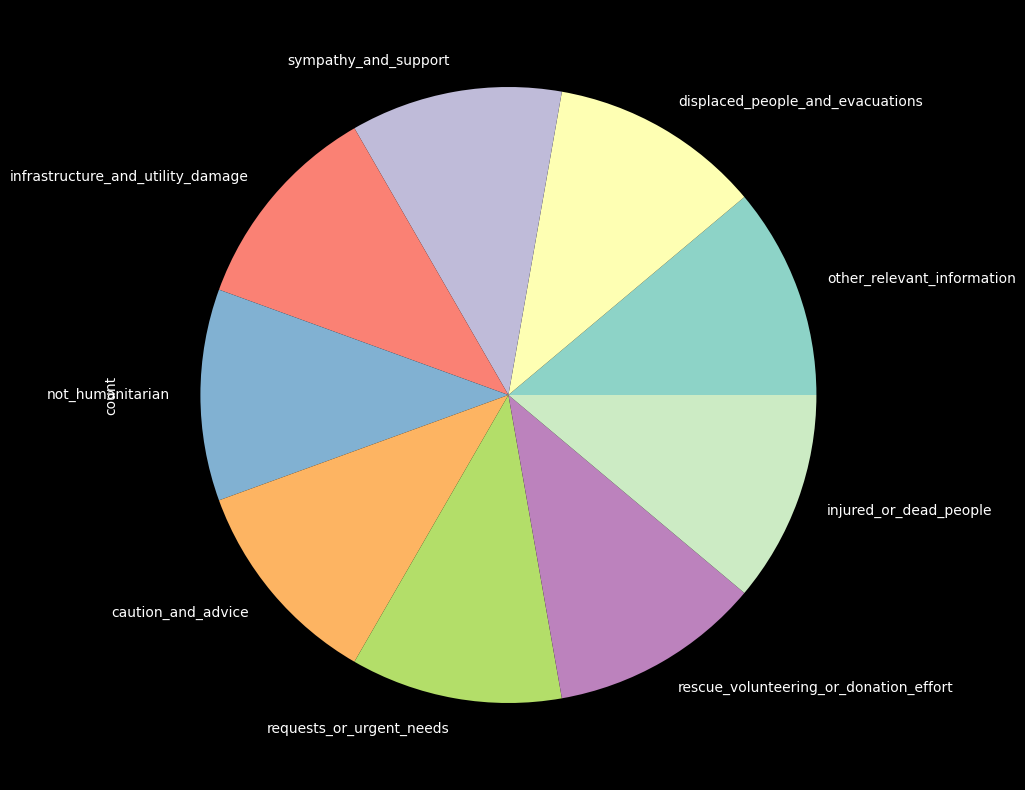

In [69]:
train_df.class_label.value_counts().plot(kind='pie', figsize=(10,10))

In [70]:
from sklearn.preprocessing import LabelEncoder

# Step 0: Ensure class labels are encoded numerically if not already
label_encoder = LabelEncoder()
train_df['class_label_num'] = label_encoder.fit_transform(train_df['class_label'])
val_df['class_label_num'] = label_encoder.transform(val_df['class_label'])
test_df['class_label_num'] = label_encoder.transform(test_df['class_label'])


train_tweets = list(train_df.tweet_text)
train_labels = list(train_df.class_label_num)

val_tweets = list(val_df.tweet_text)
val_labels = list(val_df.class_label_num)

test_tweets = list(test_df.tweet_text)
test_labels = list(test_df.class_label_num)

In [44]:
train_df['class_label_num'].unique()

array([3, 5, 8, 4, 7, 2, 1, 0, 6])

In [56]:
from sklearn.utils.class_weight import compute_class_weight

# compute class weights
class_weights = compute_class_weight('balanced', classes=train_df['class_label_num'].unique(), y=train_df['class_label_num'])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [71]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_data(text, tokenizer, max_len=256):
    return tokenizer(text, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")

In [72]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = tokenize_data(text, self.tokenizer, self.max_len)
        text_length = torch.tensor([min(len(text), self.max_len) for text in self.texts])
        return {
            'input_ids': inputs['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
        }

In [73]:

train_dataset = TweetDataset(train_tweets, train_labels, tokenizer, max_len=512)
val_dataset = TweetDataset(val_tweets, val_labels, tokenizer, max_len=512)
test_dataset = TweetDataset(test_tweets, test_labels, tokenizer, max_len=512)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [74]:
import torch.nn as nn
import torch.nn.functional as F

class DeepTextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, filter_sizes, num_filters, dropout=0.5):
        super(DeepTextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Sequential(nn.Conv2d(1, num_filters, (k, embed_dim)),
                          nn.ReLU(),
                          nn.MaxPool2d((2, 1))) for k in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        # Adjust the size below according to your filter_sizes and the number of conv layers
        self.fc1 = nn.Linear(num_filters * len(filter_sizes), num_filters) 
        self.fc2 = nn.Linear(num_filters, num_classes)
        
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add channel dim
        x = [conv(x).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [89]:
from transformers import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, data_loader, device):
    model.eval()
    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            _, preds = torch.max(outputs, dim=1)

            final_targets.extend(labels.cpu().detach().numpy())
            final_outputs.extend(preds.cpu().detach().numpy())
    
    accuracy = accuracy_score(final_targets, final_outputs)
    precision, recall, f1, _ = precision_recall_fscore_support(final_targets, final_outputs, average='weighted')
    return accuracy, precision, recall, f1, final_targets, final_outputs


model = DeepTextCNN(vocab_size=tokenizer.vocab_size, embed_dim=512, num_classes=len(set(class_labels)), filter_sizes=[2, 3, 4], num_filters=128)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 8
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch + 1}, Loss: {avg_train_loss:.4f}")

    # Validation
    accuracy, precision, recall, f1,y,y_pred = evaluate(model, val_loader, device)
    print(f"Validation Metrics: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")
    

d:\AI_Dev_Vault\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 422/422 [04:35<00:00,  1.53it/s]



Epoch 1, Loss: 2.0425
Validation Metrics: Accuracy: 0.4395, Precision: 0.5635, Recall: 0.4395, F1: 0.4433



Training Epoch 2: 100%|██████████| 422/422 [04:30<00:00,  1.56it/s]



Epoch 2, Loss: 1.5070
Validation Metrics: Accuracy: 0.5395, Precision: 0.6273, Recall: 0.5395, F1: 0.5559



Training Epoch 3: 100%|██████████| 422/422 [04:09<00:00,  1.69it/s]



Epoch 3, Loss: 1.2429
Validation Metrics: Accuracy: 0.6233, Precision: 0.6589, Recall: 0.6233, F1: 0.6306



Training Epoch 4: 100%|██████████| 422/422 [04:11<00:00,  1.68it/s]



Epoch 4, Loss: 1.0924
Validation Metrics: Accuracy: 0.6424, Precision: 0.6788, Recall: 0.6424, F1: 0.6454



Training Epoch 5: 100%|██████████| 422/422 [04:11<00:00,  1.68it/s]



Epoch 5, Loss: 1.0038
Validation Metrics: Accuracy: 0.6821, Precision: 0.6978, Recall: 0.6821, F1: 0.6828



Training Epoch 6: 100%|██████████| 422/422 [04:22<00:00,  1.61it/s]



Epoch 6, Loss: 0.9424
Validation Metrics: Accuracy: 0.6860, Precision: 0.7070, Recall: 0.6860, F1: 0.6912



Training Epoch 7: 100%|██████████| 422/422 [04:28<00:00,  1.57it/s]



Epoch 7, Loss: 0.8889
Validation Metrics: Accuracy: 0.6817, Precision: 0.7104, Recall: 0.6817, F1: 0.6860



Training Epoch 8: 100%|██████████| 422/422 [04:25<00:00,  1.59it/s]



Epoch 8, Loss: 0.8539
Validation Metrics: Accuracy: 0.6983, Precision: 0.7136, Recall: 0.6983, F1: 0.6989



In [94]:
def class_report(model, data_loader, device): 
    model.eval()
    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
            _, preds = torch.max(outputs, dim=1)

            final_targets.extend(labels.cpu().detach().numpy())
            final_outputs.extend(preds.cpu().detach().numpy())
    
    print(classification_report(final_targets, final_outputs, target_names=class_labels))

In [91]:
class_report(model, test_loader, device)

                                        precision    recall  f1-score   support

            other_relevant_information       0.52      0.68      0.59      1070
      displaced_people_and_evacuations       0.81      0.91      0.86       790
                  sympathy_and_support       0.75      0.82      0.78      1617
     infrastructure_and_utility_damage       0.87      0.92      0.89      1447
                      not_humanitarian       0.46      0.54      0.50      1245
                    caution_and_advice       0.52      0.37      0.43      2407
              requests_or_urgent_needs       0.37      0.72      0.48       521
rescue_volunteering_or_donation_effort       0.82      0.75      0.78      4219
                injured_or_dead_people       0.87      0.72      0.78      1772

                              accuracy                           0.69     15088
                             macro avg       0.67      0.71      0.68     15088
                          weighted avg

RNN (LSTM) performance

In [92]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, sent len, emb dim]
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # hidden = [num layers * num directions, batch size, hid dim]
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        # hidden = [batch size, hid dim * num directions]
        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [93]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        model.zero_grad()
        outputs = model(input_ids)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


# Initialize the mode
model = LSTMClassifier(vocab_size=tokenizer.vocab_size, embedding_dim=256, hidden_dim=128, output_dim=len(set(labels)), n_layers=2, bidirectional=True, dropout=0.2)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-3)

# Training and validation loop
num_epochs = 4
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
    
    accuracy, precision, recall, f1,y,y_pred = evaluate(model, val_loader, device)
    print(f"Validation Metrics: Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")
    

# Test
print(classification_report(y, y_pred, target_names=class_labels, digits=4))

d:\AI_Dev_Vault\Anaconda\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training: 100%|██████████| 422/422 [04:28<00:00,  1.57it/s]


Epoch 1, Train Loss: 1.5751
Validation Metrics: Accuracy: 0.5787, Precision: 0.6507, Recall: 0.5787, F1: 0.5570



Training: 100%|██████████| 422/422 [04:30<00:00,  1.56it/s]


Epoch 2, Train Loss: 0.9015
Validation Metrics: Accuracy: 0.6755, Precision: 0.6826, Recall: 0.6755, F1: 0.6645



Training: 100%|██████████| 422/422 [04:29<00:00,  1.57it/s]


Epoch 3, Train Loss: 0.7116
Validation Metrics: Accuracy: 0.6989, Precision: 0.7174, Recall: 0.6989, F1: 0.7012



Training: 100%|██████████| 422/422 [04:27<00:00,  1.58it/s]


Epoch 4, Train Loss: 0.5941
Validation Metrics: Accuracy: 0.7004, Precision: 0.7093, Recall: 0.7004, F1: 0.6925

                                        precision    recall  f1-score   support

            other_relevant_information     0.6082    0.7055    0.6532       550
      displaced_people_and_evacuations     0.8528    0.8924    0.8722       409
                  sympathy_and_support     0.7235    0.8123    0.7653       831
     infrastructure_and_utility_damage     0.9000    0.9169    0.9084       746
                      not_humanitarian     0.4301    0.6304    0.5113       644
                    caution_and_advice     0.5578    0.2694    0.3633      1236
              requests_or_urgent_needs     0.3931    0.6477    0.4893       264
rescue_volunteering_or_donation_effort     0.8401    0.7588    0.7974      2168
                injured_or_dead_people     0.7199    0.8427    0.7765       909

                              accuracy                         0.7004      7757
     

In [95]:
class_report(model, test_loader, device)

                                        precision    recall  f1-score   support

            other_relevant_information       0.61      0.66      0.64      1070
      displaced_people_and_evacuations       0.82      0.90      0.86       790
                  sympathy_and_support       0.75      0.82      0.78      1617
     infrastructure_and_utility_damage       0.90      0.92      0.91      1447
                      not_humanitarian       0.43      0.68      0.53      1245
                    caution_and_advice       0.58      0.27      0.36      2407
              requests_or_urgent_needs       0.40      0.68      0.50       521
rescue_volunteering_or_donation_effort       0.84      0.77      0.80      4219
                injured_or_dead_people       0.72      0.83      0.77      1772

                              accuracy                           0.70     15088
                             macro avg       0.67      0.72      0.68     15088
                          weighted avg